In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy
import fibsem
from fibsem.imaging import masks
from fibsem.imaging import utils   
from autoscript_sdb_microscope_client.structures import AdornedImage
from PIL import Image
import logging
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage import data
from skimage import filters
from skimage.color import rgb2gray
import imageio
import cv2
import glob
import itertools
import pandas as pd
from pprint import pprint
import plotly.express as px
import statsmodels
import ipywidgets
from dataclasses import dataclass
from skimage.feature import match_template
import skimage

In [2]:
def bp_mask(image_shape,
                 bandpass_outer_radius: int,
                 bandpass_inner_radius: int = 0,
                 bandpass_sigma: float = None):

    bandpass_mask = np.zeros(image_shape)
    r, c = np.array(image_shape) / 2
    inner_circle_rr, inner_circle_cc = skimage.draw.disk(
        (r, c), bandpass_inner_radius, shape=image_shape)
    outer_circle_rr, outer_circle_cc = skimage.draw.disk(
        (r, c), bandpass_outer_radius, shape=image_shape)
    bandpass_mask[outer_circle_rr, outer_circle_cc] = 1.0
    bandpass_mask[inner_circle_rr, inner_circle_cc] = 0.0
    bandpass_mask = np.array(bandpass_mask)
    # fourier space origin should be in the corner
    bandpass_mask = np.roll(bandpass_mask,
                            (np.array(image_shape) / 2).astype(int),
                            axis=(0, 1))
    # Soft edges help avoid ringing artifacts in results
    if bandpass_sigma is not None:
        bandpass_mask = skimage.filters.gaussian(bandpass_mask.astype(float),
                                                 sigma=bandpass_sigma)
    return bandpass_mask

def normalize(image:np.ndarray) -> np.ndarray:
    mean, std = cv2.meanStdDev(image)
    norm = (image - mean) / std
    # zero_array = np.zeros(norm.shape)
    # final_img = cv2.normalize(norm,  zero_array, 0, 1, cv2.NORM_MINMAX)
    return norm

def radial_spec(image: np.array):
    x, y = np.meshgrid(np.arange(image.shape[1]), np.arange(image.shape[0]))
    R = np.sqrt(x ** 2 + y ** 2)
    f = lambda r: image[(R >= r - .5) & (R < r + .5)].mean()
    r = np.linspace(0, 824, num = 824)
    mean = np.vectorize(f)(r)
    return r, mean

In [3]:
def xcorr(
    img1: np.ndarray, 
    img2: np.ndarray,
    hp: float=None,
    lp: float=None,
    sigma: float=None) -> np.ndarray:

    if img1.data.shape != img2.data.shape:
        err = f"Image 1 {img1.data.shape} and Image 2 {img2.data.shape} need to have the same shape"
        logging.error(err)
        raise ValueError(err)

    # Create Fourier transform
    img1fft = np.fft.fftn(img1.data)
    img2fft = np.fft.fftn(img2.data)
    # Do some shady normalization
    n_pixels1 = img1.data.shape[0] * img1.data.shape[1]
    img1fft[0, 0] = 0
    tmp = img1fft * np. conj(img1fft)
    img1fft = n_pixels1 * img1fft / np.sqrt(tmp.sum())
    n_pixels2 = img2.data.shape[0] * img2.data.shape[1]
    img2fft[0, 0] = 0
    tmp = img2fft * np. conj(img2fft)
    img2fft = n_pixels2 * img2fft / np.sqrt(tmp.sum())

    corr_mask = bp_mask(img1.shape, 200, 0, 0)

    if hp and lp and sigma is not None:
        bp = bp_mask(img1.shape, hp, lp, sigma)
        
        # Cross-correlate the two images
        temp = np.real(np.fft.ifftn((img1fft * bp) * np.conj(img2fft)))
        corr = np.fft.fftshift(temp * corr_mask)
        # Cross-correlation center and shift from center
        maxX, maxY = np.unravel_index(np.argmax(corr), corr.shape)
        cen = np.asarray(corr.shape) / 2
        err = np.array(cen - [maxX, maxY], int)
        valMax = np.amax(corr)
        return corr, err

    else:

        # Cross-correlate the two images
        temp = np.real(np.fft.ifftn((img1fft * np.conj(img2fft))))
        corr = np.fft.fftshift(temp * corr_mask)

        # Cross-correlation center and shift from center
        maxX, maxY = np.unravel_index(np.argmax(corr), corr.shape)
        cen = np.asarray(corr.shape) / 2
        err = np.array(cen - [maxX, maxY], int)
        valMax = np.amax(corr)
        return corr, err

In [4]:
# create circular mask with smooth Gaussian drop-off
def circ_mask(image:np.ndarray, mask_radius:int):
    zero_array = np.zeros(image.shape)
    mask = cv2.circle(zero_array, (412, 412), mask_radius, (1, 1, 1), -1) 
    smooth_mask = ndi.gaussian_filter(mask, 5)
    masked = image * smooth_mask
    return masked

In [5]:
ref = mpimg.imread("../ib_eb images/test/2022-10-21.01-30-34PM_eb.tif")
target = mpimg.imread("../ib_eb images/test/ref_trench_low_res_ib.tif")


c:\Users\phipo\Anaconda3\envs\fibsem\lib\site-packages\skimage\draw\draw.py:41: RuntimeWarning: invalid value encountered in divide
  distances = ((r * cos_alpha + c * sin_alpha) / r_rad) ** 2 \
c:\Users\phipo\Anaconda3\envs\fibsem\lib\site-packages\skimage\draw\draw.py:42: RuntimeWarning: invalid value encountered in divide
  + ((r * sin_alpha - c * cos_alpha) / c_rad) ** 2


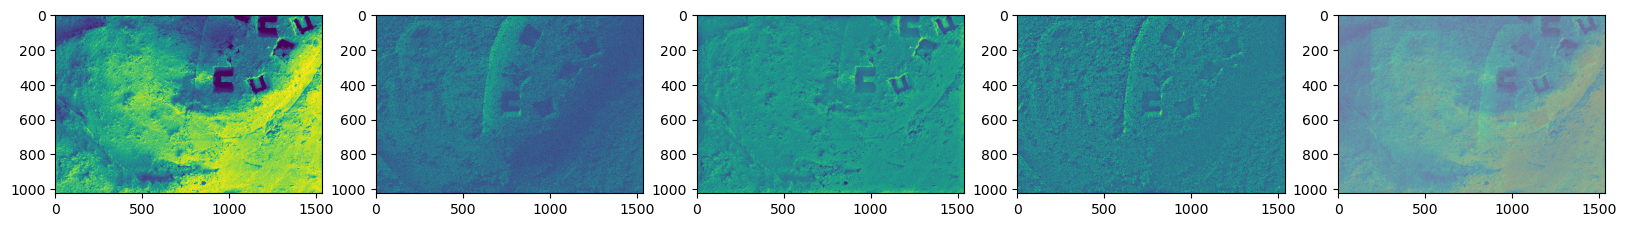

In [6]:
corr, err = xcorr(ref, ndi.rotate(target,180), 200, 5, 5)
bp = bp_mask(ref.shape, 200, 10 ,5)
ib_fft_mask = np.fft.fftn(ref) * bp
ib_mask = np.real(np.fft.ifftn(ib_fft_mask))
fl_fft_mask = np.fft.fftn(ndi.rotate(target, 180)) * bp
fl_mask = np.real(np.fft.ifftn(fl_fft_mask))

fig, ax = plt.subplots(1,5,figsize=(20,20))
ax[0].imshow(ref)
ax[1].imshow(ndi.rotate(target, 180))
ax[2].imshow(ib_mask)
ax[3].imshow(ndi.rotate(fl_mask, 0))
ax[4].imshow(ref, alpha=0.5)
ax[4].imshow(np.roll(ndi.rotate(target, 180), shift=(err), axis=(0,1)), alpha=0.5)

In [7]:
import numpy as np
from scipy.signal import fftconvolve


def normxcorr2(template, image, mode="full"):
    # If this happens, it is probably a mistake
    if np.ndim(template) > np.ndim(image) or \
            len([i for i in range(np.ndim(template)) if template.shape[i] > image.shape[i]]) > 0:
        print("normxcorr2: TEMPLATE larger than IMG. Arguments may be swapped.")

    template = template - np.mean(template)
    image = image - np.mean(image)

    a1 = np.ones(template.shape)
    # Faster to flip up down and left right then use fftconvolve instead of scipy's correlate
    ar = np.flipud(np.fliplr(template))
    out = fftconvolve(image, ar.conj(), mode=mode)
    
    image = fftconvolve(np.square(image), a1, mode=mode) - \
            np.square(fftconvolve(image, a1, mode=mode)) / (np.prod(template.shape))

    # Remove small machine precision errors after subtraction
    image[np.where(image < 0)] = 0

    template = np.sum(np.square(template))
    out = out / np.sqrt(image * template)

    # Remove any divisions by 0 or very close to 0
    out[np.where(np.logical_not(np.isfinite(out)))] = 0
    
    return out

In [11]:
cc = scipy.signal.fftconvolve(ref, ndi.rotate(target,180)[::-1, ::-1])

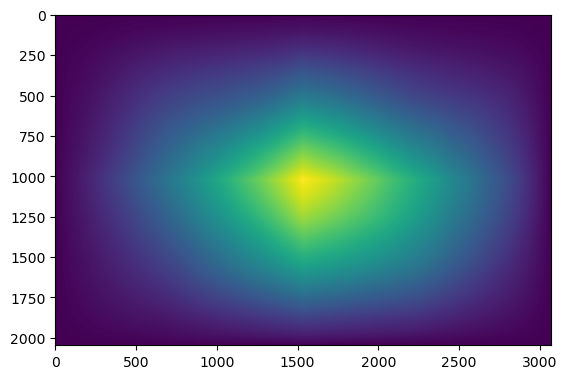

In [12]:
scipy.signal.fftconvolve()